##  self-attention mechanism with trainable weights
the self-attention mechanism with trainable weights builds on the previous concepts: we want to compute context vectors as weighted sums over the input vectors specific to a certain input element.

The most notable difference is the introduction of weight matrices that are updated during model training. These trainable weight matrices are crucial so that the model (specifically, the attention module inside the model) can learn to produce "good" context vectors.

### Computing the attention weights step by step
We will implement the self-attention mechanism step by step by introducing the three trainable weight matrices Wq, Wk, and Wv. These three matrices are used to project the
embedded input tokens, x^i, into query, key, and value vectors.
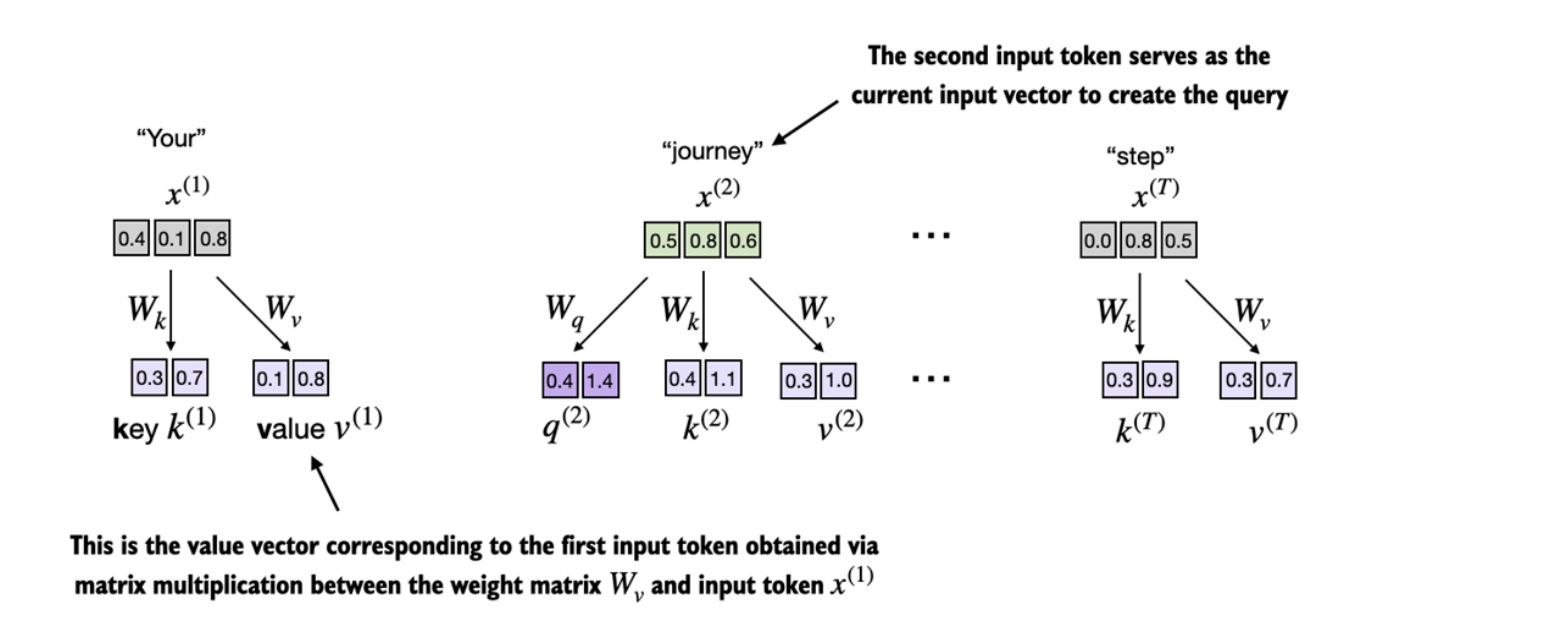

In [1]:
import torch
inputs = torch.tensor(
    [[0.43, 0.15, 0.89], # Your (x^1)
    [0.55, 0.87, 0.66], # journey (x^2)
    [0.57, 0.85, 0.64], # starts (x^3)
    [0.22, 0.58, 0.33], # with (x^4)
    [0.77, 0.25, 0.10], # one (x^5)
    [0.05, 0.80, 0.55]] # step (x^6)
)

Note that in GPT-like models, the input and output dimensions are usually the same, but for
illustration purposes, to better follow the computation, we choose different input (d_in=3)
and output (d_out=2) dimensions here.


In [2]:
x_2 = inputs[1] #The second input element
d_in = inputs.shape[1] #The input embedding size, d=3
d_out = 2 # The output embedding size, d_out=2

Next, we initialize the three **weight matrices** Wq, Wk, and Wv.
Note that we are setting **requires_grad=False** to **reduce clutter**(means making the printed outputs easier to read while learning) in the outputs for
illustration purposes, but if we were to use the weight matrices for model training, we
would set **requires_grad=True** to update these matrices during model training.


In [9]:
torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

In [8]:
W_query

Parameter containing:
tensor([[0.2961, 0.5166],
        [0.2517, 0.6886],
        [0.0740, 0.8665]], requires_grad=True)

In [5]:
W_key

Parameter containing:
tensor([[0.1366, 0.1025],
        [0.1841, 0.7264],
        [0.3153, 0.6871]])

In [6]:
W_value

Parameter containing:
tensor([[0.0756, 0.1966],
        [0.3164, 0.4017],
        [0.1186, 0.8274]])

Next, we compute the query, key, and value vectors

In [13]:
query_2 = x_2 @ W_query
key_2 = x_2 @ W_key
value_2 = x_2 @ W_value

As we can see based on the output for the query, this results in a 2-dimensional vector
since we set the number of columns of the corresponding weight matrix, via d_out, to 2:

In [14]:
query_2

tensor([0.4306, 1.4551])

In [11]:
key_2

tensor([0.4433, 1.1419])

In [12]:
value_2

tensor([0.3951, 1.0037])

Even though our temporary goal is to only compute the one context vector, z^2, we still require the key and value vectors for all input elements as they are involved in computing
the attention weights with respect to the query q^2.
We can obtain all keys and values via **matrix multiplication**:

In [15]:
keys = inputs @ W_key
values = inputs @ W_value
print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


In [16]:
keys

tensor([[0.3669, 0.7646],
        [0.4433, 1.1419],
        [0.4361, 1.1156],
        [0.2408, 0.6706],
        [0.1827, 0.3292],
        [0.3275, 0.9642]])

In [17]:
values

tensor([[0.1855, 0.8812],
        [0.3951, 1.0037],
        [0.3879, 0.9831],
        [0.2393, 0.5493],
        [0.1492, 0.3346],
        [0.3221, 0.7863]])

The **second step** is now to compute the **attention scores**
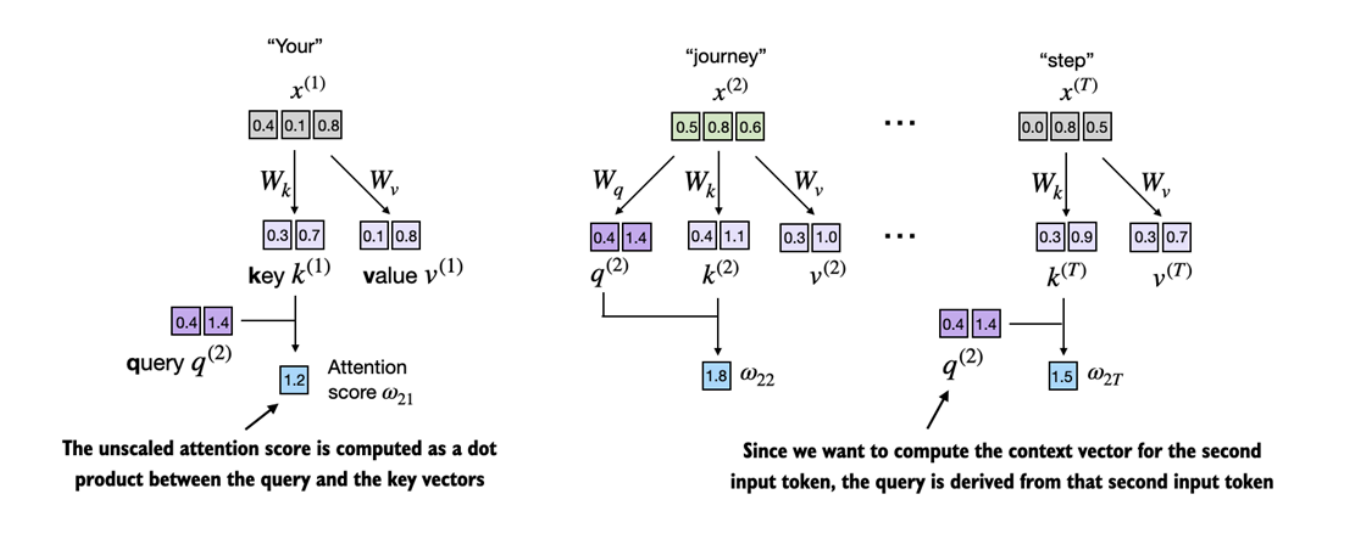

In [18]:
keys.T

tensor([[0.3669, 0.4433, 0.4361, 0.2408, 0.1827, 0.3275],
        [0.7646, 1.1419, 1.1156, 0.6706, 0.3292, 0.9642]])

In [19]:
# First, let's compute the attention score ω22:
keys_2 = keys[1] 
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22)

tensor(1.8524)


Again, we can generalize this computation to all attention scores via matrix multiplication:

In [20]:
attn_scores_2 = query_2 @ keys.T # All attention scores for given query
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


The **third step** is now going from the **attention scores** to the **attention weights**
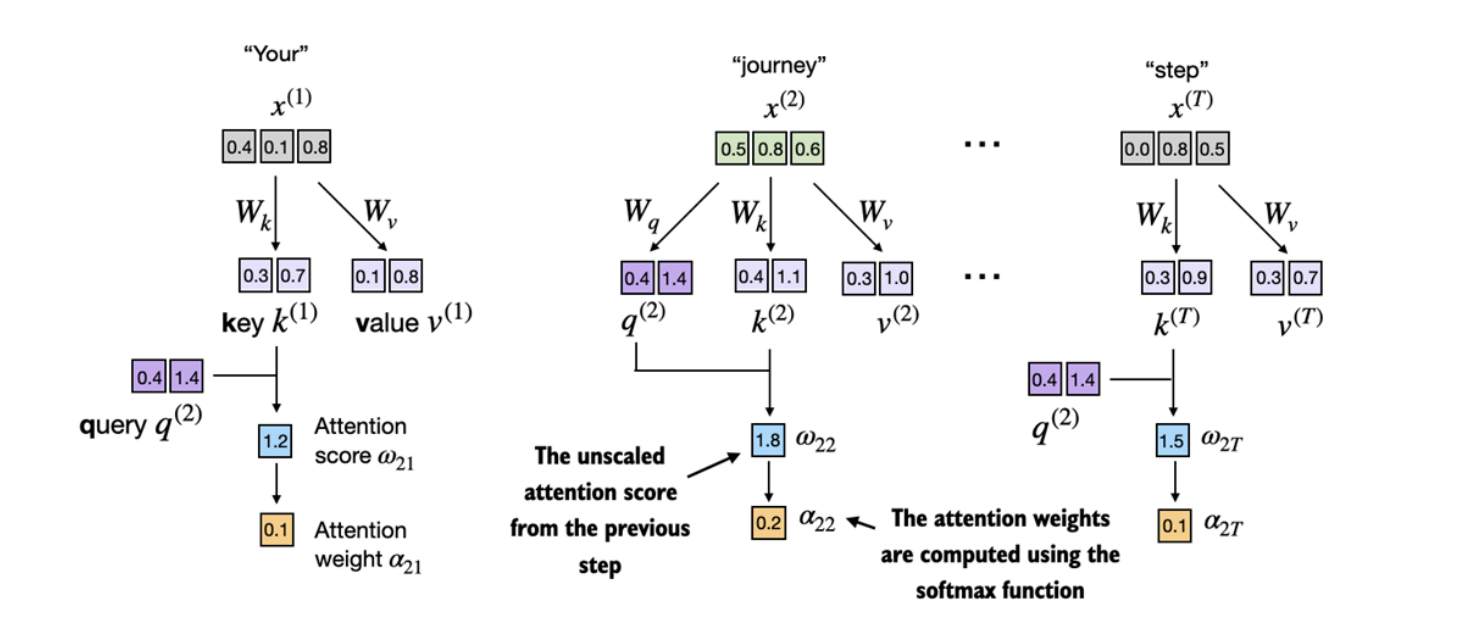
After computing the **attention scores** ω, the next step is to normalize these scores using the **softmax** function to obtain the attention weights α

In [21]:
d_k = keys.shape[-1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
print(attn_weights_2)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


**THE RATIONALE BEHIND SCALED-DOT PRODUCT ATTENTION** <br>
The reason for the normalization by the embedding dimension size is to improve the training performance by avoiding small gradients. For instance, when scaling up the embedding dimension, which is typically greater than thousand for GPT-like LLMs, large dot products can result in very small gradients during backpropagation due to the softmax function applied to them. As dot products increase, the softmax function behaves more like a step function, resulting in gradients nearing zero. These small gradients can drastically slow down learning or cause training to stagnate. The scaling by the square root of the embedding dimension is the reason why this self-attention mechanism is also called scaled-dot product attention.

Now, the **final step** is to compute the **context vectors**
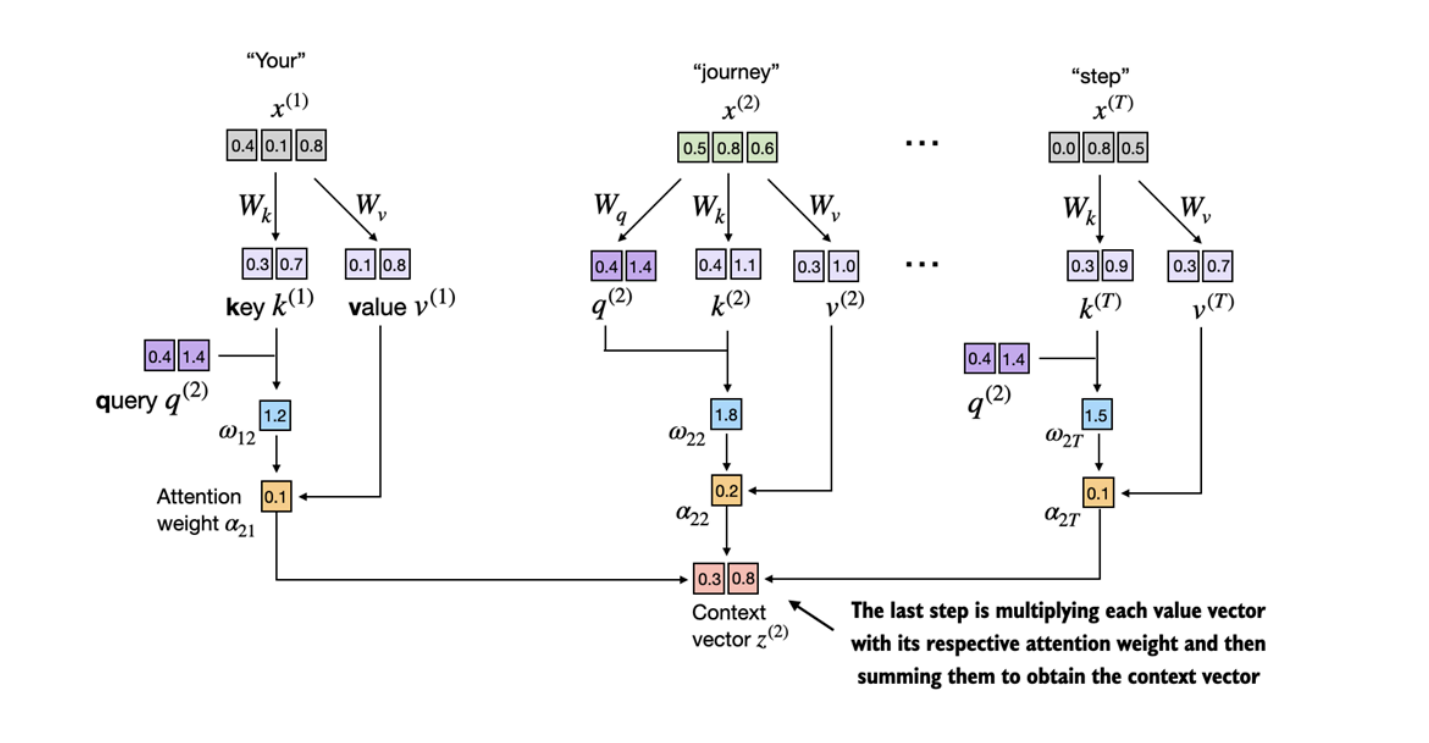
In the final step of the self-attention computation, we compute the context vector by combining all value vectors via the attention weights

In [22]:
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.3061, 0.8210])


**WHY QUERY, KEY, AND VALUE?**<br>
The terms "key," "query," and "value" in the context of attention mechanisms are borrowed from the domain of information retrieval and databases, where similar concepts are used to store, search, and retrieve information. <br>

- A **query** is analogous to a search query in a database. It represents the current item (e.g., a word or token in a sentence) the model focuses on or tries to understand. The query is used to probe the other parts of the input sequence to determine how much attention to pay to them. <br>

- The **key** is like a database key used for indexing and searching. In the attention mechanism, each item in the input sequence (e.g., each word in a sentence) has an associated key. These keys are used to match with the query. <br>

- The **value** in this context is similar to the value in a key-value pair in a database. It represents the actual content or representation of the input items. Once the model determines which keys (and thus which parts of the input) are most relevant to the query (the current focus item), it retrieves the corresponding values.

### Implementing a compact self-attention Python class

In [23]:
import torch.nn as nn
class SelfAttention_v1(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Parameter(torch.rand(d_in, d_out))
        self.W_key = nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = nn.Parameter(torch.rand(d_in, d_out))
    def forward(self, x):
        keys = x @ self.W_key
        queries = x @ self.W_query
        values = x @ self.W_value
        attn_scores = queries @ keys.T # omega
        attn_weights = torch.softmax(
        attn_scores / keys.shape[-1]**0.5, dim=-1)
        context_vec = attn_weights @ values
        return context_vec

In [24]:
torch.manual_seed(123)
sa_v1 = SelfAttention_v1(d_in, d_out)
print(sa_v1(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


###  A self-attention class using PyTorch's Linear layers

In [25]:
class SelfAttention_v2(nn.Module):
    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        context_vec = attn_weights @ values
        return context_vec

In [26]:
torch.manual_seed(789)
sa_v2 = SelfAttention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


**COMPARING SELFATTENTION_V1 AND SELFATTENTION_V2**<br>
Although SelfAttention_v1 and SelfAttention_v2 implement the same self-attention math, their outputs differ due to implementation details.

1. **Weight definition**

**v1**
 ```
self.W_query = nn.Parameter(torch.rand(d_in, d_out))
```
- Weights are created manually using torch.rand
- No bias term
- Simple but not how PyTorch layers are usually implemented

**v2**
```
self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
```
- Uses PyTorch’s nn.Linear
- Internally computes:
    - x @ W.T + bias
- Uses a more stable, training-friendly initialization

2. **Bias term**

- **v1**: No bias (pure matrix multiplication)
- **v2**: Bias is optional (qkv_bias=True/False)

Even small bias values can significantly change:

- Attention scores
- Softmax distribution
- Final context vectors

3. **Weight initialization**

- **v1**: torch.rand() → values in [0, 1)
- **v2**: nn.Linear → Kaiming/He initialization (better scaled)

Different initialization ⇒ different dot-product magnitudes ⇒ different attention weights.